In [2]:
# loading package
#並合併train&test data
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
sns.set(font_scale=1.56)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
# loading data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_data = df_train.append(df_test)
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.filterwarnings("ignore")

,Sex,Survived
0,female,0.742
1,male,0.189


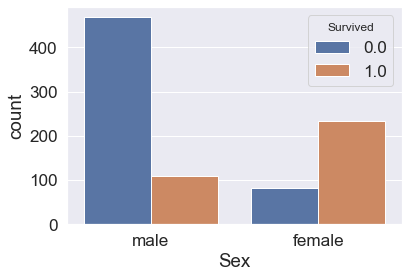

In [3]:
#首先設定一個最基本的模型，如果之後加入的特徵在準確率表現上比這個差，就可以判定該特徵含有太多噪聲，或是和生存與否關係不大，
#在鐵達尼號的資料集裡，我們從兩個特徵開始:
#(1) 性別 : 在鐵達尼號中，大部分的男性都掛了(僅剩18%存活)，而女性則大部分都存活了下來(~75%)
sns.countplot(df_data['Sex'], hue=df_data['Survived'])
display(df_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().round(3))

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


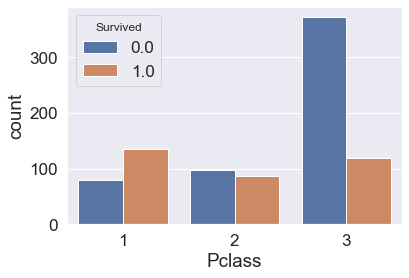

In [4]:
#(2) 艙等 : 我們可以預期到，頭等艙的乘客生存機率會比較高，不論是逃生設備，或是沈船訊息可能最先傳到頭等艙，
#鐵達尼號有3個艙等 : 1,2,3 (姑且稱為頭等艙、商務艙和經濟艙XD?)
sns.countplot(df_data['Pclass'], hue=df_data['Survived'])
df_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(3)

In [5]:
# Convert Sex 將性別資料轉換為 0, 1，0為女性，1為男性
df_data['Sex_Code'] = df_data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')

In [6]:
# split training set the testing set，將生還與否設定為目標(Y)，其餘為訓練資料(X)
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

In [7]:
#訓練隨機森林模型，利用Out-Of-Bag的data做為驗證資料集，
#Out-Of-Bag的data:隨機森林演算法是由一群決策樹組成，單顆決策樹並不會用所有的訓練資料，每一次選一塊資料來訓練一顆決策樹時，
#剩下的資料並沒有被拿來訓練該顆決策樹，因此可以做為驗證資料，即Out-Of-Bag。
#超參數調整
#這篇文章的分析主要著重在特徵工程上，因此這裡並沒有選用最佳化的參數來訓練模型，其中有幾個選項，
#分別是max_depth, min_samples_split, min_samples_leaf......etc，其實都是為了防止overfitting，這裡我們簡單地選用min_samples_split=20。
# Inputs set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [8]:
# Show Baseline
Base = ['Sex_Code','Pclass']
Base_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_))
#我們在oob資料上獲得0.731的準確率，將結果提交到Kaggle上，我們在排行榜上獲得0.76555的準確率，這是一個基準值，如果你已經加入了很多特徵，
#但是準確率比0.76555低，表示你加入了太多噪聲很大的特徵，或是你的模型參數已經調過頭導致了overfitting，
#此時該做的就是回到最簡單的Base Model，一項一項特徵慢慢地加入。

Base oob score :0.73176


In [9]:
# submission if you want
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

Base_pred = Base_Model.predict(X_Submit[Base])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":Base_pred.astype(int)})
submit.to_csv("submit_Base.csv",index=False)

Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

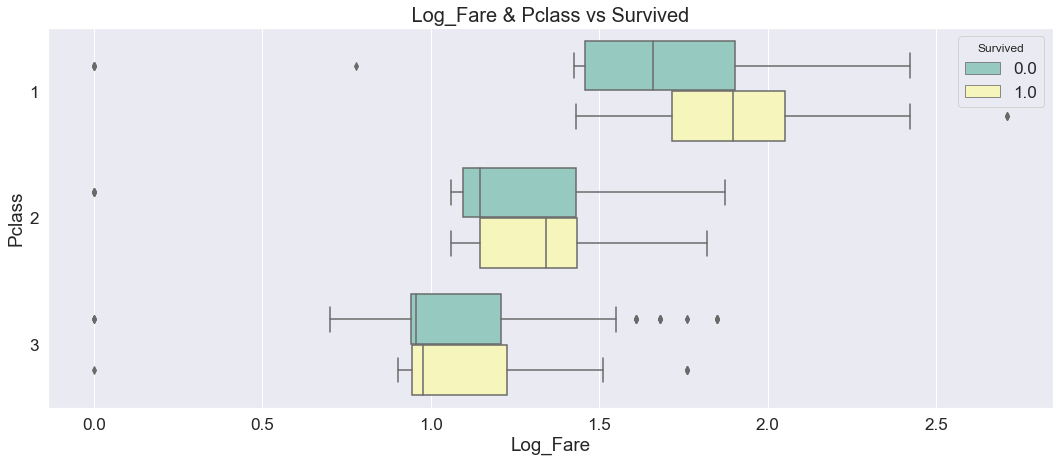

In [10]:
#票價和艙等都是屬於彰顯乘客社會地位的一個特徵，同時也可以在EDA當中發現，買票價格較高的乘客，他們的生存機率也較高。
#由於票價分布非常廣及傾斜，有非常高的票價也有非常低的，我們將票價取log來畫圖會好看一點。
#(註 : 取log之後同時也可以解決傾斜的問題，若是在Regression Problem中也是必要的預處理)
# there is some bugs in log-scale of boxplot. 
# alternatively, we transform x into log10(x) for visualization.
fig, ax = plt.subplots( figsize = (18,7) )
df_data['Log_Fare'] = (df_data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare',hue='Survived',data=df_data, orient='h'
                ,ax=ax,palette="Set3")
ax.set_title(' Log_Fare & Pclass vs Survived ',fontsize = 20)
pd.pivot_table(df_data,values = ['Fare'], index = ['Pclass'], columns= ['Survived'] ,aggfunc = 'median' ).round(3)
#票價取log vs 艙等，其中黃色的盒子為存活下來的，綠色反之，中線為票價取log之後的中位數。
#從表以及圖中我們都可以看出存活下來的乘客確實平均而言付出較高的票價，我們決定測試這個特徵

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


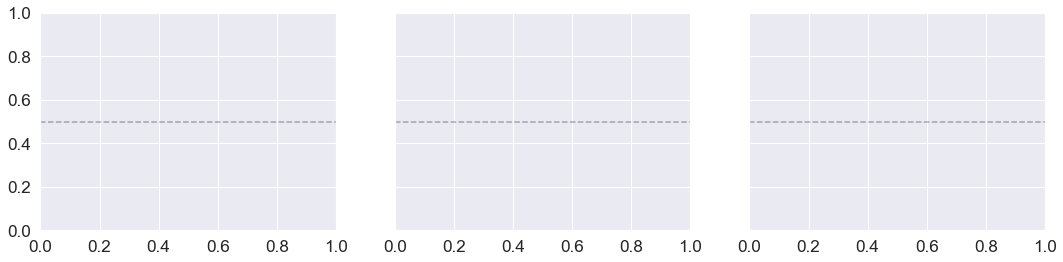

In [11]:
# Filling missing values，由於只有一項缺失值，故用中位數填入
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())

#我們用極限的觀點來考慮區間切分問題 :
#當切分的區間太少時，區間內的資料太多一起平均，這樣沒有辦法看出差異性，使得特徵失真
#當切分區間太多時，一點點票價的不同，都影響了生存率的高低，如此一來很明顯地會overfitting，並且，切分區間趨近於無限大時，就回到了原本的數值特徵
#下列程式碼將票價分別切分成4,5,6的區間，並命名為新的特徵
# Making Bins
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)

label = LabelEncoder()
df_data['FareBin_Code_4'] = label.fit_transform(df_data['FareBin_4'])
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])
df_data['FareBin_Code_6'] = label.fit_transform(df_data['FareBin_6'])

# cross tab
df_4 = pd.crosstab(df_data['FareBin_Code_4'],df_data['Pclass'])
df_5 = pd.crosstab(df_data['FareBin_Code_5'],df_data['Pclass'])
df_6 = pd.crosstab(df_data['FareBin_Code_6'],df_data['Pclass'])

display_side_by_side(df_4,df_5,df_6)

# plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5,linestyle='dashed', c='black',alpha = .3)
g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", data=df_data,kind='bar',ax=ax1)
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", data=df_data,kind='bar',ax=ax2)
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", data=df_data,kind='bar',ax=ax3)
# close FacetGrid object
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

In [12]:
# splits again beacuse we just engineered new feature
#這裡有兩件值得提的事，Pandas中提供了蠻多種切分數值特徵的方式，這裡選用qcut，qcut是以累積百分比來切分的，
#例如將副指令=4，就會以0%~25%, 25%~50%, 50%~75%, 75%~100% 來切分資料，好處是我們可以避免某個區間內的資料過少(skew problem)。
#圖中虛線表示為機器隨機亂猜，應該要有50%的準確率，如果我們的特徵工程沒辦法將各區間分離開50%，那就沒什麼意義。
#切分訓練集及測試集，將生還與否設為目標(Y)，其餘為訓練資料(X)，並顯示目前有的特徵ㄒ
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']
# show columns
X.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Sex_Code', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')

In [13]:
#對於這樣一個特徵選擇(Feature Slection)的問題，這裡我們利用前向選擇法(RFE)做特徵選擇，關於特徵選擇的方法我們有幾個選項，
#一是用單變數的Chi square、或是information gain，但RFE可以考慮到特徵之間的交互作用，缺點是需要較大的運算資源，
#這點由於我們的資料集比較少而可以獲得緩解，在Sklearn上的實作也蠻簡單的
compare = ['Sex_Code','Pclass','FareBin_Code_4','FareBin_Code_5','FareBin_Code_6']
selector = RFECV(RandomForestClassifier(n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
selector.fit(X[compare], Y)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100)

[ True  True  True  True  True]
[1 1 1 1 1]
[78.67290886 77.55430712 79.3545568  79.57677903 80.1423221 ]


In [14]:
#在CV上我們可以看到切分成6份可以得到比較高的CV分數，但是還沒有考慮到模型的random_state以及Cross-Validation切分的方式，
#我們必須小心謹慎的確認切成6份是否真的是最好的，下面針對CV及模型的random_state進行實驗，這段程式會稍微花一點時間，作者的i5筆電花了2分36秒
score_b4,score_b5, score_b6 = [], [], []
seeds = 10
for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
    selector = RFECV(RandomForestClassifier(random_state=i,n_estimators=250,min_samples_split=20),cv=diff_cv,n_jobs=-1)
    selector.fit(X[compare], Y)
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])

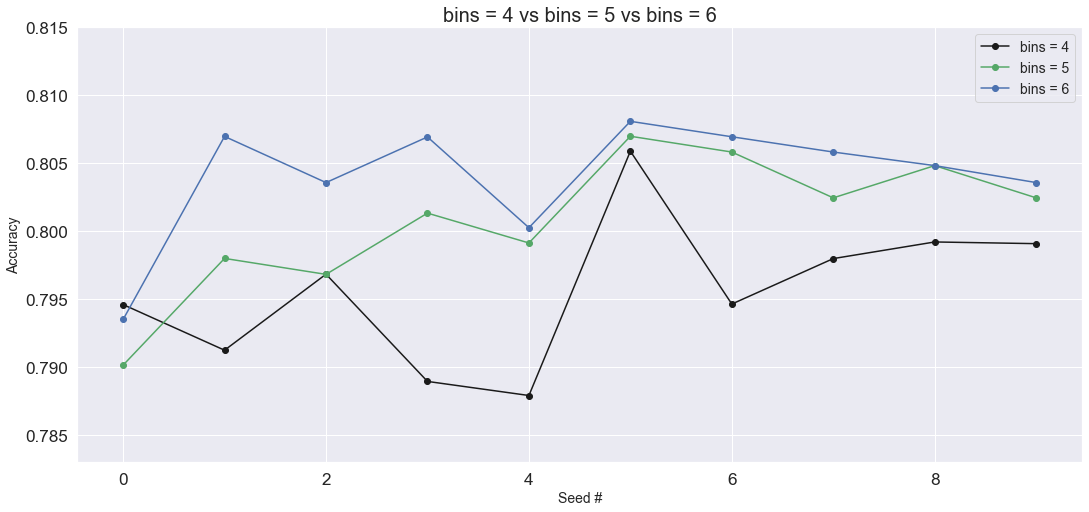

In [15]:
# to np.array
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)
# plot
fig = plt.figure(figsize= (18,8) )
ax = plt.gca()
ax.plot(range(seeds), score_b4,'-ok',label='bins = 4')
ax.plot(range(seeds), score_b5,'-og',label='bins = 5')
ax.plot(range(seeds), score_b6,'-ob',label='bins = 6')
ax.set_xlabel("Seed #", fontsize = '14')
ax.set_ylim(0.783,0.815)
ax.set_ylabel("Accuracy", fontsize = '14')
ax.set_title('bins = 4 vs bins = 5 vs bins = 6', fontsize='20')
plt.legend(fontsize = 14,loc='upper right')

In [16]:
#由上圖我們可以看出切分成4份的準確率較低，6份比5份稍微好一點，在CV在的結果是這樣，接下來我們分別將其提交到Kaggle上，
#這段程式碼和上面Base Model差不多，所以這裡就不再重複一次，我們直接顯示oob分數以及提交的結果
b4, b5, b6 = ['Sex_Code', 'Pclass','FareBin_Code_4'], ['Sex_Code','Pclass','FareBin_Code_5'],\
['Sex_Code','Pclass','FareBin_Code_6']
b4_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_Model.fit(X[b4], Y)
b5_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_Model.fit(X[b5], Y)
b6_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_Model.fit(X[b6], Y)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),'   LB_Public : 0.7790')
print('b5 oob score :%.5f '%(b5_Model.oob_score_),' LB_Public : 0.79425')
print('b6 oob score : %.5f' %(b6_Model.oob_score_), '  LB_Public : 0.77033')
#這裡我們可以看到，在排行榜上的分數反而是切分成5份最高分，而不是6份，這個情況在Titanic這個資料集上很常見，
#作者認為是某種過度的特徵工程所帶來的overfitting，畢竟特徵工程在數學上也可以想像成原始特徵的非線性轉換，
#僅僅是我們賦予了每一種特徵工程對應的意義，然後相信這樣做是有用的，最終都必須得在CV以及排行榜上測試
#(P.S.這段僅僅是依照作者的經驗來寫)

b4 oob score :0.80584    LB_Public : 0.7790
b5 oob score :0.81033   LB_Public : 0.79425
b6 oob score : 0.80135   LB_Public : 0.77033


In [17]:
# submits，將b5_Model提交至Kaggle
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

b5_pred = b5_Model.predict(X_Submit[b5])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":b5_pred.astype(int)})
submit.to_csv("submit_b5.csv",index=False)
#可以得到0.79425的準確率，事實上，在Kaggle上這已經是Top22%的排名了，這也顯示出，
#多數的Kaggler在鐵達尼號這個比賽中都用了許多噪聲(noise)強或是互相冗餘(redundant)的特徵。

In [18]:
#連結(Connected_Survival)這個特徵相當有意思，主要是發現了乘客持有相同的船票意味著他們可能是家人或是朋友，
#而在訓練集上這些互相有連結的人常常是一起活下來或是一起喪命，我們從票根的特徵Ticket開始看起
df_train['Ticket'].describe()
#在891個票根資訊中，獨立的有681項，這表示一定有乘客是持有相同的票根，這意味著他們可能一起分享某一區的座位......
#建立家庭人數特徵(將兄弟姊妹數SibSp+父母小孩數Parch+1)方便接下來的觀察

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [19]:
# Family_size
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1

In [20]:
#建立持有相同票根的DataFrame，並顯示姓名、票價、艙位、家庭人數
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

#觀察表格，從編號7,24,374,567,389這個群組來看，該家族有可能是全部一起喪命的(縱使有一個是測試集中的資料)，也可以從姓名中看出，
#5名成員皆為Palsson家族，一位先生(Mr.)及兩位小姐(Miss)帶著兩位小男孩(Master)搭上了鐵達尼號，票根皆為349909，甚至票價也是同樣的，
#接著再看到編號8,172,869群組，皆為Johnson家族的成員，兩位女性(Mrs.及Miss)帶著一位小男孩(Master)搭上了船，這則是一個三位乘客皆存活的例子，
#也未必所有的群組都是同生同死(例如編號3,137)，最後，我們可以從編號6,146的這個群組看出兩位一起搭船，但並非是親屬關係(姓名中的姓氏不同)，
#因此可以推定可能是朋友或是基於甚麼原因共同搭船的人，同樣也有可能在船難發生時互相幫忙

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [21]:
#也可以透過家庭成員人數這個特徵來分類，Family_size = 1 但是又在群組內的，即非親屬關係，我們歸類為朋友，Family_size > 1則為家人
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size > 1]))
#有約莫600位乘客和他人持有相同票根，其中大概有75%為家庭出遊。接著依照以觀察來創建一個新的特徵，這個部分感謝網友 @孫茂勛 參與討論，
#指出原本解釋不妥的部分，這讓我們的分析更加完整以及更容易閱讀，以下我們進入特徵工程的細節:

,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596 
friends: 127 
families: 469 


In [22]:
#我們希望上表中票根 PC 17599 中的乘客建立Connected_Survival = 1，以及票根 17463 349909 中的乘客建立Connected_Survival = 0，
#但還須要多考慮沒有生還資訊的乘客(同個票根中Survived都是NaN 在測試集中)的乘客，將Connected_Survival = 0.5
#過濾出重複的票根 : if( len(df_grp) > 1)
#如果群組中有人生還 則定義 Connected_Survival = 1 : if(smax == 1.0):
#沒有人生還，則定義Connected_Survival = 0 : if( smin == 0.0):
#剩下的沒有生還資訊，定義Connected_Survival = 0.5 : 程式碼第一行 df_data['Connected_Survival'] = 0.5

# the same ticket family or friends
df_data['Connected_Survival'] = 0.5 # default 
for _, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(df_data[df_data['Connected_Survival']!=0.5].shape[0]))
df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [23]:
#上表中我們得到在596位持有彼此持有相同票根的乘客，其中496位含有連結關係(0 or 1 )，將其分組分別計算生還率，也還能把資料分的蠻開的，
#其中連結=1的生存率更是從0.298直接飆升至0.728

#完成特徵工程，分離訓練集、測試集，並分離出生還與否(Y)以及訓練資料(X)
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [25]:
#加入模型、訓練、觀察oob score
connect = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20
                                       ,oob_score=True)
connect_Model.fit(X[connect], Y)
print('connect oob score :%.5f' %(connect_Model.oob_score_))


connect oob score :0.82043


In [26]:
#oob score來到了0.820，將預測提交至Kaggle觀看結果

# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

connect_pred = connect_Model.predict(X_Submit[connect])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":connect_pred.astype(int)})
submit.to_csv("submit_connect.csv",index=False)

#我們從0.79425來到了0.80382，這表示我們加入了一個相當有效果的特徵!

Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


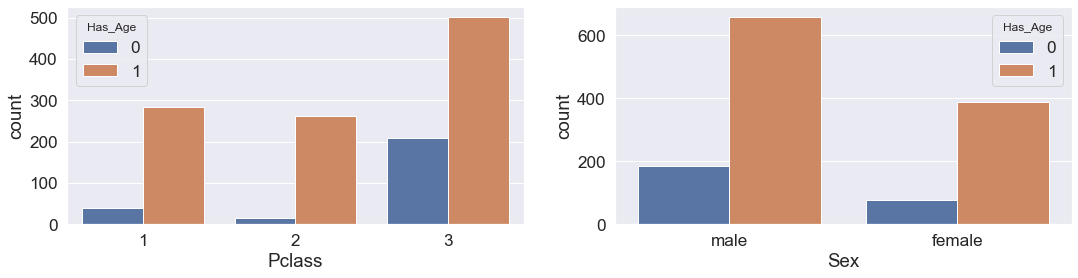

In [27]:
#年齡(Age)
#在這個特徵中我們會面臨20%缺失值的問題，和前面的票價(Fare)僅僅只有一項缺失值相比，缺的不少，而這很有可能影響預測，首先我們分兩個部分來討論:
#截止目前為止，使用性別及艙等可以達到0.76555的準確率，後來加入了2項特徵則約莫提升了4%，因此如果缺失年齡特別都屬於某個性別，
#或是特別都屬於某個艙等，就很有可能影響預測，以下觀察缺失值分佈的情況

df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(df_data['Pclass'],hue=df_data['Has_Age'],ax=ax1)
ax2 = sns.countplot(df_data['Sex'],hue=df_data['Has_Age'],ax=ax2)
pd.crosstab(df_data['Has_Age'],df_data['Sex'],margins=True).round(3)

#左下: 是否缺失年齡對艙等的統計，右下: 是否缺失年齡對性別的統計
#從左圖我們可以明顯的看出年齡缺失值蠻大部分在3等艙，如果年齡真的是個重要特徵，則我們對3等艙的觀察就會失真，
#保守的作法是觀察1,2艙等中年齡對存活與否的影響。
#右圖則顯示了缺失值對性別的分布，搭配著表格看的話，466位女性有78位缺失年齡(16.7%)，843位男性有185位缺失年齡(21.9%)，
#比例差了5%，男性缺失年齡稍微多一點，如果年齡對生存與否有影響的話，
#可能可以搭配男性藉此被區分出更多的生還者(例如男性小孩生還率有可能高於男性成人)

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1 and  2')

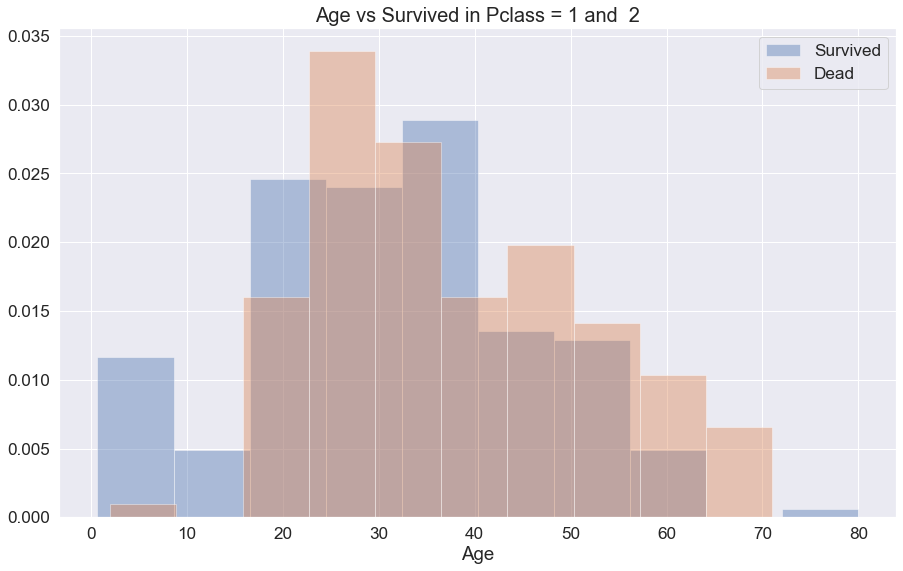

In [28]:
#1,2艙之中，年齡對存活與否的影響:
# Masks
Mask_Has_Age_P12_Survived = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 1) )
Mask_Has_Age_P12_Dead = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 0) )
# Plot
fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Survived, 'Age'],kde=False,bins=10,norm_hist=True,label='Survived') 
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Dead, 'Age'],kde=False,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass = 1 and  2',fontsize = 20)

#圖中我們可以看到，左邊藍色的部分多出了一塊，也就是這部分生存率較高的，約<16歲，表示青少年以下(包含小孩)會有較高的生存率，
#同時，其餘部分也顯示出了，若>16歲，基本上年齡不算是一個顯著的特徵來判定是否生還，而70~80歲的這個區間，由於樣本數太少，因此不列入採計。
#綜合上述3張圖的討論，我認為找出那些<16歲的缺失值是重要的，這會影響預測，而>16歲的部分則不採用，否則只是擬合了噪聲，
#因此年齡這個特徵可以抽取出<16歲及>16歲做為一個2元特徵

In [29]:
# extracted title using name，填入缺失值的方式我們選擇使用姓名當中的稱謂中位數來填補，比起填中位數要準確的多
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'],'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
Ti = df_data.groupby('Title')['Age'].median()
Ti
#列表為年齡中位數，先生 - 29歲，罕見稱謂 - 47歲，小男孩 - 4歲，小姐- 22歲， 女士 - 36歲。

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

In [30]:
#不動原始特徵Age，將填滿年齡的特徵創建為Ti_Age，分為<16歲及>16歲，命名為Ti_Minor
Ti_pred = df_data.groupby('Title')['Age'].median().values
df_data['Ti_Age'] = df_data['Age']
# Filling the missing age
for i in range(0,5):
 # 0 1 2 3 4 5
    df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i),'Ti_Age'] = Ti_pred[i]
df_data['Ti_Age'] = df_data['Ti_Age'].astype('int')
df_data['Ti_Minor'] = ((df_data['Ti_Age']) < 16.0) * 1

In [31]:
#完成特徵工程，分離訓練集、測試集，分離出生還與否(Y)以及訓練資料(X)
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [32]:
#加入模型、訓練、觀察oob score
minor = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival','Ti_Minor']
minor_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
minor_Model.fit(X[minor], Y)
print('minor oob score :%.5f' %(minor_Model.oob_score_))


minor oob score :0.84175


In [33]:
#得到了0.8417的oob score，也有可能是overfittng!，將結果提交至Kaggle
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

minor_pred = minor_Model.predict(X_Submit[minor])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":minor_pred.astype(int)})
submit.to_csv("submit_minor.csv",index=False)
#分數來到了0.0.81100

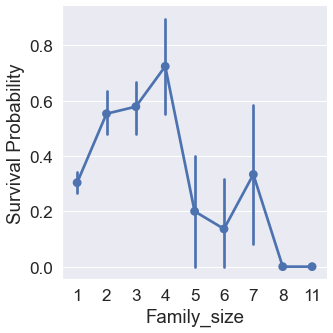

In [34]:
#家庭人數(Family_size)
#家庭人數這個特徵作者最後並沒有加入模型，加入時雖然CV時升高，但提交到Kaggle時分數卻降低，雖然板上的前輩說要相信CV的分數，
#但作者認為這個特徵是冗餘(redundant)的，雖然可以用correlation matrix來確認相關性，但實際上仍然有許多特徵之間的關係是非線性的，
#討論區上也發表了家庭人數可能是冗餘的相關言論，我們來看看
g = sns.factorplot(x='Family_size', y='Survived',data=df_data)
g = g.set_ylabels("Survival Probability")

In [34]:
#我們可以看到獨自一人的生存機率低，2~4人的家庭生還機率比較高，之後隨著人數增加而遞減，
#這時候我們就可能會腦補 : 獨自一人可能逃生時沒有受到幫助，所以生還率低，2~4人可以互相幫忙，
#但是人太多時可能又會因為無法找齊全部的家人逃生時有猶豫等等，而將其分成3類，獨自一人，2~4人，5人以上，分析如下
# cut into 3 class
df_data['L_Family'] = df_data['Family_size'].apply(lambda x: 0 if x<= 4 else 1).astype(int)
df_data.loc[ df_data['Family_size'] == 1, 'FamilyClass'] = 0
df_data.loc[ (df_data['Family_size'] <= 4) & (df_data['Family_size'] > 1), 'FamilyClass'] = 1
df_data.loc[ df_data['Family_size'] >= 5, 'FamilyClass'] = 2
df_data['FamilyClass'] = df_data['FamilyClass'].astype(int) 
df_data[['FamilyClass','Survived']].groupby(['FamilyClass']).mean()

,Survived
FamilyClass,
0,0.303538
1,0.578767
2,0.161290


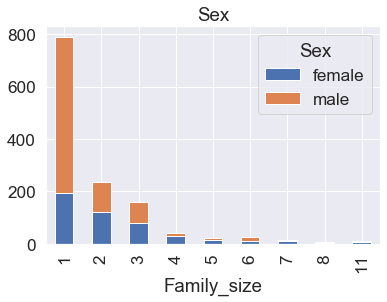

In [35]:
#然而，這有可能只是我們的空想，我們來看看家庭人數對性別的分析圖形
# display(pd.crosstab(df_data['Sex'],df_data['Family_size'],margins=True))
# visualize
pd.crosstab(df_data['Family_size'],df_data['Sex']).plot(kind='bar',stacked=True,title="Sex")
#我們看家庭人數=1，真的是因為獨自一人沒有受到幫助而導致較低的生存率嗎? 有可能，但是不見得，
#下表中我們可以清楚看到家庭人數=1之中有接近將近75%的男性，男性的生存率本來就低，FamilyClass=0很有可能僅僅是性別特徵的一個重複而已!

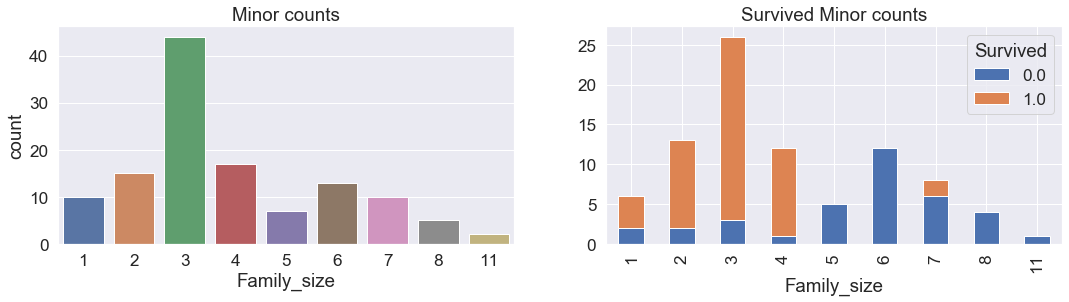

In [36]:
#然而家庭人數2~4呢? 是否真的是因為互相幫忙導致的生存率提高 還是又是其他特徵的投射而已? 我們來看家庭人數對小孩數量的分析
Minor_mask = (df_data.Ti_Minor == 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
sns.countplot(df_data[Minor_mask]['Family_size'],ax=ax1)
ax1.set_title("Minor counts")
pd.crosstab(df_data[Minor_mask]['Family_size'],df_data[Minor_mask]['Survived'])\
.plot(kind='bar',stacked=True,title="Survived Minor counts",ax=ax2)

#在家庭人數=2,3,4中，除了小孩的個數較高之外，存活的比例也非常高，這意味著家庭人數=2~4人的生存率較高很有可能僅僅是小孩存活的多，
#這已經涵蓋在Minor的特徵當中!
#至於剩下的 Family_size >5人呢? 從分析中並沒有看出和其他特徵相關的影子，
#但如果我們僅是猜測其生還率低的原因是因為找不到其他家人猶豫而降低了生還率，這個理由我們在連結(Connected_Survival)已經做過同樣的推測，
#若僅是因為這個理由多造一個特徵，那確確實實又是冗餘了!